<h1>Notebook. Open new Ice cream shop</h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [95]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests as HttpRequest/Response
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


We use the geopy library to get latitude and longitude values of Rimini.

In [68]:
address = "Rimini, IT"

geolocator = Nominatim(user_agent = "rimini_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("latitude: {}, longitude: {}".format(latitude, longitude))

latitude: 44.0593886, longitude: 12.5684371


In [84]:
map_rimini = folium.Map(location = [latitude, longitude], zoom_start = 13)

map_rimini

We start to utilizing the Foursquare Api to explore the neighborhoods and segment them.

In [110]:
CLIENT_ID = 'hidden' # your Foursquare ID
CLIENT_SECRET = 'hidden' # your Foursquare Secret
VERSION = 'hidden' # Foursquare API version

We create the funcions to get all info from each neighborhood in Rimini.

In [69]:
#function for get nearby venues
def getNearbyVenues(names, latitudes, longitudes, venue = "", radius=3000, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'ID Venue',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    #filtering for venue
    if(venue != ""):
        nearby_venues = nearby_venues[nearby_venues["Venue Category"].str.contains(venue)].reset_index(drop = True)
    
    return(nearby_venues)

In [6]:
#function for get given venues
def getGivenVenue(df_venues):
    
    rating_list = []
    
    for idVenue in df_venues["ID Venue"]:
        
        #create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(idVenue, CLIENT_ID, CLIENT_SECRET, VERSION)
        
        #make the GET request
        results = requests.get(url).json()['response']
        
        #return only relevant information for each venue
        rating_list.append([results['venue']['id'], results['venue']['rating']])
        
    given_venues = pd.DataFrame(rating_list)
    given_venues.columns = ["ID Venue", "Rating"]
    
    return(given_venues)

We create a dataframe for the call and to obtain the necessary informations.

In [70]:
df = pd.DataFrame(columns = ["Neighborhood", "Latitude", "Longitude"])

df = df.append({
    "Neighborhood": "Rimini",
    "Latitude": latitude,
    "Longitude": longitude
}, ignore_index = True)

In [71]:
#get nearby venues
rimini_venues = getNearbyVenues(df["Neighborhood"], df["Latitude"], df["Longitude"], venue = "Ice Cream Shop")

rimini_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID Venue,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rimini,44.059389,12.568437,4c7d4e57b53db1f793b49c11,Gelateria La Romana,44.061999,12.567570,Ice Cream Shop
1,Rimini,44.059389,12.568437,4bdc89912a3a0f47be4db3b6,Gelateria Il Castello,44.058969,12.563041,Ice Cream Shop
2,Rimini,44.059389,12.568437,4fa440f9e4b08e1f87f70c9b,Puro & Bio,44.057315,12.560378,Ice Cream Shop
3,Rimini,44.059389,12.568437,4d8df2ce1716a1439c1125f7,Gelateria Marselli,44.056169,12.575805,Ice Cream Shop
4,Rimini,44.059389,12.568437,4fce6990e4b0f39ffff84921,Gelateria Biologica Santa Colomba,44.060680,12.564600,Ice Cream Shop


In [85]:
#map the ice cream shops
map_rimini = folium.Map(location = [latitude, longitude], zoom_start = 13)

for venue, lat, lon in zip(rimini_venues["Venue"], rimini_venues["Venue Latitude"], rimini_venues["Venue Longitude"]):
    
    label = folium.Popup("Venue: " + str(venue), parse_html = True)
    
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = "blue",
        fill = True,
        fill_opacity = 0.7).add_to(map_rimini)

map_rimini

In [74]:
#Get given venues
rimini_given_venues = getGivenVenue(rimini_venues)

In [75]:
rimini_given_venues

,ID Venue,Rating
0,4c7d4e57b53db1f793b49c11,8.8
1,4bdc89912a3a0f47be4db3b6,8.5
2,4fa440f9e4b08e1f87f70c9b,8.5
3,4d8df2ce1716a1439c1125f7,8.4
4,4fce6990e4b0f39ffff84921,8.0
5,4c2a14649eb1952136dd2959,8.5
6,4d289a5bc406721e991673b6,7.9
7,4c49eb6aa3ace21e4649423c,7.6


In [76]:
#Join the two dataframe
rimini_venues = pd.merge(rimini_venues, rimini_given_venues, on = "ID Venue")

rimini_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID Venue,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Rimini,44.059389,12.568437,4c7d4e57b53db1f793b49c11,Gelateria La Romana,44.061999,12.567570,Ice Cream Shop,8.8
1,Rimini,44.059389,12.568437,4bdc89912a3a0f47be4db3b6,Gelateria Il Castello,44.058969,12.563041,Ice Cream Shop,8.5
2,Rimini,44.059389,12.568437,4fa440f9e4b08e1f87f70c9b,Puro & Bio,44.057315,12.560378,Ice Cream Shop,8.5
3,Rimini,44.059389,12.568437,4d8df2ce1716a1439c1125f7,Gelateria Marselli,44.056169,12.575805,Ice Cream Shop,8.4
4,Rimini,44.059389,12.568437,4fce6990e4b0f39ffff84921,Gelateria Biologica Santa Colomba,44.060680,12.564600,Ice Cream Shop,8.0
5,Rimini,44.059389,12.568437,4c2a14649eb1952136dd2959,Gelateria La Romana - Fuoriporta,44.057028,12.552893,Ice Cream Shop,8.5
6,Rimini,44.059389,12.568437,4d289a5bc406721e991673b6,3BIS Gelateria Artigeniale,44.067088,12.581282,Ice Cream Shop,7.9
7,Rimini,44.059389,12.568437,4c49eb6aa3ace21e4649423c,Pellicano Beach,44.070172,12.580153,Ice Cream Shop,7.6


In [106]:
#clean dataframe with relevant informations
venues = rimini_venues[["Venue", "Venue Latitude", "Venue Longitude", "Rating"]].copy()

venues.rename(columns = { "Venue Latitude": "Latitude", "Venue Longitude": "Longitude"}, inplace = True)

venues

,Venue,Latitude,Longitude,Rating
0,Gelateria La Romana,44.061999,12.567570,8.8
1,Gelateria Il Castello,44.058969,12.563041,8.5
2,Puro & Bio,44.057315,12.560378,8.5
3,Gelateria Marselli,44.056169,12.575805,8.4
4,Gelateria Biologica Santa Colomba,44.060680,12.564600,8.0
5,Gelateria La Romana - Fuoriporta,44.057028,12.552893,8.5
6,3BIS Gelateria Artigeniale,44.067088,12.581282,7.9
7,Pellicano Beach,44.070172,12.580153,7.6


We use KMeans algorithm for determine the clusters of ice cream shops.

In [93]:
SumOfSquaredDistances = []
K = range(1,8)

for k in K:
    
    kmeans = KMeans(n_clusters = k, random_state = 0)
    
    kmeans = kmeans.fit(venues.drop("Venue", 1))
    
    SumOfSquaredDistances.append(kmeans.inertia_)

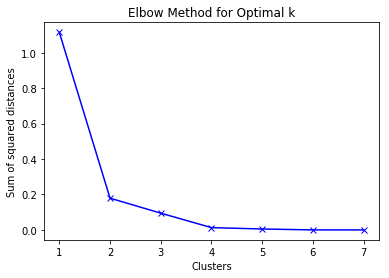

In [96]:
plt.plot(K, SumOfSquaredDistances, "bx-")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method for Optimal k")
plt.show()

After see the graphic we choose to use 4 clusters because use an above  number at four will not change the result of algorithm.

In [97]:
#run k-means clustering
kmeans = KMeans(n_clusters = 4, random_state = 0)
kmeans.fit(venues.drop("Venue", 1))

#check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 1, 1, 1, 0, 1, 0, 2], dtype=int32)

We add the labels at the relative venue.

In [107]:
#add clustering labels
venues.insert(4, "Cluster", kmeans.labels_)

In [108]:
venues

,Venue,Latitude,Longitude,Rating,Cluster
0,Gelateria La Romana,44.061999,12.567570,8.8,3
1,Gelateria Il Castello,44.058969,12.563041,8.5,1
2,Puro & Bio,44.057315,12.560378,8.5,1
3,Gelateria Marselli,44.056169,12.575805,8.4,1
4,Gelateria Biologica Santa Colomba,44.060680,12.564600,8.0,0
5,Gelateria La Romana - Fuoriporta,44.057028,12.552893,8.5,1
6,3BIS Gelateria Artigeniale,44.067088,12.581282,7.9,0
7,Pellicano Beach,44.070172,12.580153,7.6,2


In [109]:
#get mean rating of each cluster
df_rating = venues[["Cluster", "Rating"]].copy()

df_rating = df_rating.groupby(["Cluster"]).mean()

df_rating

,Rating
Cluster,
0,7.950
1,8.475
2,7.600
3,8.800


We create the map with the clusters of ice cream shops.

In [104]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 14)
clusters = 4

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
for lat, lon, venue, rating, cluster in zip(venues["Latitude"], venues["Longitude"], venues["Venue"], venues["Rating"], venues["Cluster"]):
    
    label = folium.Popup("Venue: " + str(venue) + ", Cluster: " + str(cluster) + ", Rating: " + str(rating), parse_html = True)
    
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster -1],
        fill = True,
        fill_color = rainbow[cluster -1],
        fill_opacity = 0.7).add_to(map_clusters)
    
map_clusters